# Load data, preprocess and run baseline prompt

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from dspy_judge.llm_caller.utils import load_secrets
from dspy_judge.data_loader.dataset_loader import CustomerSupportDatasetLoader
from dspy_judge.llm_caller import AnthropicStructuredOutputCaller, OpenAITextOutputCaller, GeminiStructuredOutputCaller
from dspy_judge.processor.parallel_processor import ParallelProcessor
from dspy_judge.prompts.pydantic_models import JudgeResponse
from dspy_judge.processor.utils import extract_llm_response_fields, concat_company_and_conversation, concat_latest_response, concat_latest_response_dspy
from dspy_judge.prompts.dspy_signatures import SupportTranscriptNextResponse
from dspy_judge.processor.conversation_truncator import ConversationTruncator
from dspy_judge.prompts.base_prompts import baseline_customer_response_support_system_prompt
import dspy
import seaborn as sns
import textstat
import matplotlib.pyplot as plt

In [4]:
secrets = load_secrets()

## Load conversations

In [5]:
data_loader = CustomerSupportDatasetLoader()

In [6]:
dataset = data_loader.load_dataset(split="train")

Loading dataset TNE-AI/customer-support-on-twitter-conversation (split: train)...


Generating train split: 100%|██████████████████████████████████████████████████████████████████| 794335/794335 [00:00<00:00, 2376817.45 examples/s]

Dataset loaded successfully. Size: 794335


In [22]:
dataset[140]

{'conversation_id': '96cdb78ceae061a11092da35a6777622',
 'company': 'AmericanAir',
 'conversation': "Customer: cld you pls update passengers of AA5 from DFW as to status of 2nd plane on this service after mech failure? Are we flying out?\nSupport: We know you're anxious to be on your way. We'll have an update on AA5 at 7p. Thanks for your patience.\nCustomer: another half hour added to terminal monitor. 7.5 hr delay on AA5. One $12 meal voucher. Abominably poor communication. Cmon AA!\nCustomer: @AmericanAir OMG, the same thing happened today and nearly 8 hours sort it out.\nSupport: Please have them reach out to us directly so we can take a look at this.",
 'summary': ''}

In [7]:
processed_dataset = data_loader.preprocess_dataset(dataset)

Map: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 773541/773541 [12:40<00:00, 1016.56 examples/s]


In [8]:
data_loader.save_dataset_locally(processed_dataset,"datasets/preprocessed_full_dataset")

Saving the dataset (1/1 shards): 100%|███████████████████████████████████████████████████████████████████████████████████████| 773541/773541 [00:00<00:00, 808058.63 examples/s]

Dataset saved to datasets/preprocessed_full_dataset


In [9]:
pre_processed_loaded  = data_loader.load_local_dataset("datasets/preprocessed_full_dataset")

Local dataset loaded from datasets/preprocessed_full_dataset. Size: 773541


## Truncate conversations

In [15]:
truncator = ConversationTruncator(seed=101)
truncated_dataset = truncator.process_dataset(
    pre_processed_loaded,
    min_turns=1,
    ensure_customer_last=True
)
truncated_dataset = truncated_dataset.map(concat_company_and_conversation)

Map: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 773541/773541 [00:17<00:00, 43713.90 examples/s]


In [16]:
data_loader.save_dataset_locally(truncated_dataset,"datasets/preprocessed_full_dataset_truncated")

Saving the dataset (2/2 shards): 100%|███████████████████████████████████████████████████████████████████████████████████████| 773541/773541 [00:01<00:00, 429830.47 examples/s]

Dataset saved to datasets/preprocessed_full_dataset_truncated


In [17]:
truncated_loaded_sampled = data_loader.get_sample(truncated_dataset,n_samples=400,seed=10)

In [18]:
truncated_loaded_sampled

Dataset({
    features: ['conversation_id', 'company', 'conversation', 'conversation_word_count', 'conversation_language', 'truncated_conversation', 'company_and_transcript'],
    num_rows: 400
})

## Run baseline model

### Option 1: dspy generation


In [51]:
# Create DSPy configuration for multiprocessing
dspy_config = {
  "model_name": "openai/gpt-3.5-turbo",
  "api_key": secrets["OPENAI_API_KEY"],
  "signature_class": SupportTranscriptNextResponse,
  "temperature": 1
}

support_transcript_generator_module = dspy.ChainOfThought(SupportTranscriptNextResponse)

# Initialize processor with both module and config
dspy_judge_processor = ParallelProcessor(
  dspy_module=support_transcript_generator_module,
  dspy_config=dspy_config
)

# Now this should work without pickling errors
dspy_judge_results = dspy_judge_processor.process_dataset_with_dspy(
  truncated_loaded_sampled,
  input_field="company_and_transcript"
)

Processing 400 examples with 4 workers using DSPy...


Processing with DSPy:   0%|                                                                                                                             | 0/400 [00:00<?, ?it/s]2025/08/02 20:36:42 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/02 20:36:42 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/02 20:36:42 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/02 20:36:42 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/02 20:36:43 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/02 20:36:43 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
Processing with DSPy:   0%|▎                                                          

In [57]:
dspy_baseline_results = dspy_judge_results.map(concat_latest_response_dspy)

Map: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 13512.14 examples/s]


In [58]:
dspy_baseline_output_pd = dspy_baseline_results.to_pandas()

In [60]:
dspy_baseline_output_pd["count_words_response"] = dspy_baseline_output_pd["dspy_response"].apply(
    lambda x: len(x["llm_response"].split())
)
dspy_baseline_output_pd["output_readability"] = dspy_baseline_output_pd["dspy_response"].apply(
    lambda x: textstat.flesch_reading_ease(x["llm_response"])
)

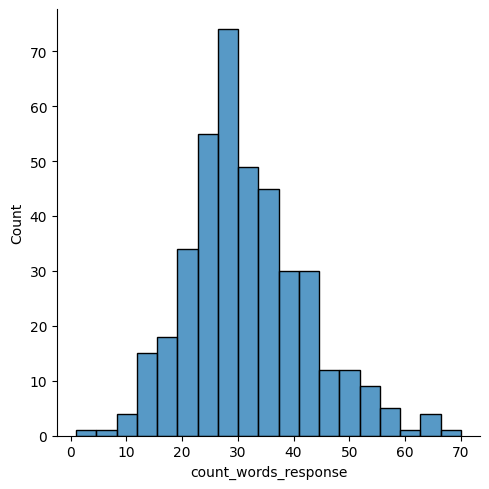

In [61]:
sns.displot(data=dspy_baseline_output_pd,x="count_words_response")

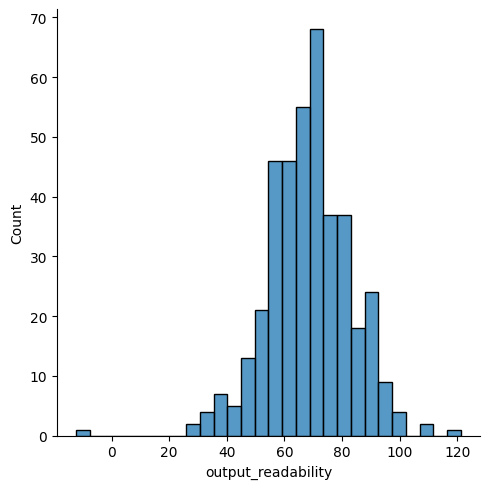

In [62]:
sns.displot(data=dspy_baseline_output_pd,x="output_readability")

### Option 2: Generate using traditional approach

In [36]:
baseline_model_name = "gpt-3.5-turbo"
baseline_model = OpenAITextOutputCaller(api_key=secrets["OPENAI_API_KEY"])
baseline_processor = ParallelProcessor(baseline_model, max_workers=4)
baseline_results = baseline_processor.process_dataset(
        truncated_loaded_sampled,
        system_prompt=baseline_customer_response_support_system_prompt,
        model_name=baseline_model_name,
        input_field="company_and_transcript",
        temperature=1.0
    )

Processing 400 examples with 4 workers...


Processing with LLM: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:12<00:00,  5.48it/s]


In [40]:
baseline_results = baseline_results.map(concat_latest_response)

Map: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 12233.46 examples/s]


In [41]:
baseline_results_pd = baseline_results.to_pandas()

In [47]:
baseline_results_pd["count_words_response"] = baseline_results_pd["llm_response"].apply(lambda x: len(x.split()))
baseline_results_pd["output_readability"] = baseline_results_pd["llm_response"].apply(lambda x: textstat.flesch_reading_ease(x))

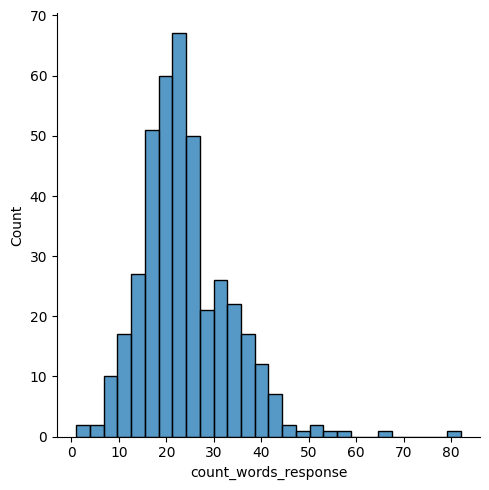

In [45]:
sns.displot(data=baseline_results_pd,x="count_words_response")

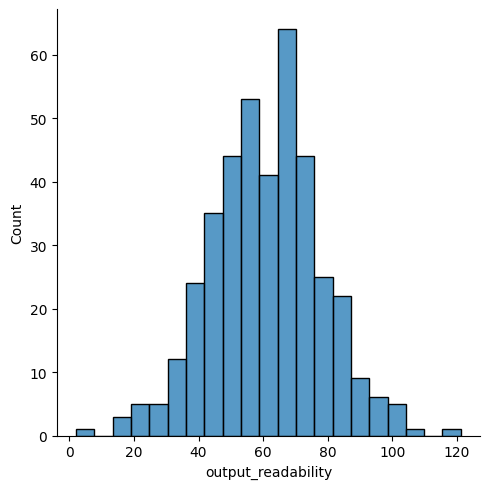

In [50]:
sns.displot(data=baseline_results_pd,x="output_readability")

## Split the output dataset

Train will be the dev dataset, test will be the dataset we'll use for judge validation

In [63]:
split_ds = dspy_baseline_results.train_test_split(test_size=0.4, seed=10)

In [64]:
data_loader.save_dataset_locally(split_ds,"datasets/preprocessed_dev_judge_dataset_split")

Saving the dataset (1/1 shards): 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 27472.11 examples/s]

Dataset saved to datasets/preprocessed_dev_judge_dataset_split
